# Week 11: Feature Engineering & Model Explainability

## 🎯 What You'll Learn This Week

This is arguably the **most important practical week** in the entire curriculum. Why? Because in real-world quant jobs:

> "A good feature with a simple model beats a complex model with bad features" - Every senior quant ever

**By the end of this week, you'll understand:**
- How to create powerful features from raw price data
- How to select the BEST features (and throw away the noise)
- How to explain WHY your model made a prediction (crucial for stakeholders!)

**Why This Matters for Your Career:**
- **Portfolio managers** won't trust a "black box" - they need explanations
- **Regulators** require model explainability (MiFID II, GDPR)
- **Interviewers** love asking: "How would you explain this model's decision?"

---

## 📚 This Week's Journey

| Days | Topic | What You'll Build |
|------|-------|------------------|
| 1-2 | Feature Engineering | Return, volatility, technical features |
| 3-4 | Feature Selection | Filter, wrapper, and embedded methods |
| 5-6 | Model Explainability | SHAP values, permutation importance |
| 7 | Complete Pipeline | Production-ready interpretable ML system |

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

print("✅ Libraries loaded!")
print("📚 Week 11: Feature Engineering & Explainability")

✅ Libraries loaded!
📚 Week 11: Feature Engineering & Explainability


---

# Part 1: Feature Engineering Fundamentals

## 🤔 Why Feature Engineering Matters (Real Talk)

Imagine you're building a model to predict if Apple stock will go up tomorrow. You could give the model:

**Option A (Bad):** Just yesterday's price ($150.23)
**Option B (Good):** Yesterday's return, 5-day momentum, RSI, volatility, volume spike...

Option B wins every time! The model can find patterns in *transformations* of price data that aren't visible in raw prices.

**The Quant's Secret:** 80% of your time should be on features, 20% on models.

### Categories of Financial Features (Your Toolkit)

| Category | Examples | What It Captures |
|----------|----------|------------------|
| **Returns** | Daily, 5-day, 20-day returns | How much did price move? |
| **Volatility** | Rolling std, Parkinson, GARCH | How "wild" is the market? |
| **Technical** | RSI, MACD, Bollinger Bands | Overbought/oversold signals |
| **Volume** | OBV, VWAP, volume ratios | Is money flowing in or out? |
| **Cross-Asset** | Sector returns, SPY correlation | What's the market doing? |

### ⚠️ The #1 Mistake Beginners Make: Data Leakage!

**Data leakage** = Using information you wouldn't have in real trading.

❌ **Wrong:** Using today's closing price to predict today's direction
✅ **Right:** Using yesterday's data to predict today's direction

Always ask: "Would I actually have this information at trading time?"

In [2]:
# ============================================================
# GENERATE REALISTIC FINANCIAL DATA
# ============================================================

print("GENERATING FINANCIAL DATA")
print("="*60)

np.random.seed(42)
n_days = 1500

# Simulate price with trends and volatility clustering
returns = []
vol = 0.015
for i in range(n_days):
    # GARCH-like volatility
    if i > 0:
        vol = 0.9 * vol + 0.1 * abs(returns[-1]) + 0.01 * np.random.normal(0, 0.005)
        vol = np.clip(vol, 0.005, 0.05)
    
    ret = np.random.normal(0.0002, vol)
    returns.append(ret)

returns = np.array(returns)
prices = 100 * np.cumprod(1 + returns)

# Create volume
base_volume = 1e6
volume = base_volume * (1 + 0.5 * np.abs(returns) / np.std(returns) + 0.3 * np.random.randn(n_days))
volume = np.maximum(volume, 1e5)

df = pd.DataFrame({
    'price': prices,
    'returns': returns,
    'volume': volume,
    'high': prices * (1 + np.abs(np.random.randn(n_days) * 0.01)),
    'low': prices * (1 - np.abs(np.random.randn(n_days) * 0.01)),
    'open': prices * (1 + np.random.randn(n_days) * 0.005)
})

print(f"Data shape: {df.shape}")
print(f"Date range: {n_days} days")

GENERATING FINANCIAL DATA
Data shape: (1500, 6)
Date range: 1500 days


## 1.1 Return-Based Features

In [3]:
# ============================================================
# RETURN FEATURES
# ============================================================

print("RETURN-BASED FEATURES")
print("="*60)

# Multiple time horizons
for period in [1, 5, 10, 20, 60]:
    df[f'ret_{period}d'] = df['price'].pct_change(period)

# Momentum (sum of returns)
for period in [5, 10, 20]:
    df[f'mom_{period}d'] = df['returns'].rolling(period).sum()

# Acceleration (change in momentum)
df['momentum_accel'] = df['mom_5d'] - df['mom_5d'].shift(5)

# Price position in range
df['price_position'] = (df['price'] - df['low'].rolling(20).min()) / \
                       (df['high'].rolling(20).max() - df['low'].rolling(20).min())

print("Created return features:")
for col in df.columns:
    if 'ret' in col or 'mom' in col or 'accel' in col or 'position' in col:
        print(f"  • {col}")

RETURN-BASED FEATURES
Created return features:
  • returns
  • ret_1d
  • ret_5d
  • ret_10d
  • ret_20d
  • ret_60d
  • mom_5d
  • mom_10d
  • mom_20d
  • momentum_accel
  • price_position


## 1.2 Volatility Features

In [4]:
# ============================================================
# VOLATILITY FEATURES
# ============================================================

print("VOLATILITY FEATURES")
print("="*60)

# Standard volatility
for period in [5, 10, 20, 60]:
    df[f'vol_{period}d'] = df['returns'].rolling(period).std()

# Parkinson volatility (uses high-low range)
df['parkinson_vol'] = np.sqrt(
    (1 / (4 * np.log(2))) * 
    (np.log(df['high'] / df['low'])**2).rolling(20).mean()
)

# Volatility of volatility
df['vol_of_vol'] = df['vol_20d'].rolling(20).std()

# Volatility ratio (short vs long)
df['vol_ratio'] = df['vol_5d'] / df['vol_20d']

# Volatility regime
vol_median = df['vol_20d'].rolling(252).median()
df['vol_regime'] = (df['vol_20d'] > vol_median).astype(int)

print("Created volatility features:")
for col in df.columns:
    if 'vol' in col:
        print(f"  • {col}")

VOLATILITY FEATURES
Created volatility features:
  • volume
  • vol_5d
  • vol_10d
  • vol_20d
  • vol_60d
  • parkinson_vol
  • vol_of_vol
  • vol_ratio
  • vol_regime


## 1.3 Technical Indicators

In [5]:
# ============================================================
# TECHNICAL INDICATORS
# ============================================================

print("TECHNICAL INDICATORS")
print("="*60)

# RSI
def calculate_rsi(returns, period=14):
    gains = returns.where(returns > 0, 0).rolling(period).mean()
    losses = (-returns.where(returns < 0, 0)).rolling(period).mean()
    rs = gains / (losses + 1e-10)
    return 100 - (100 / (1 + rs))

df['rsi'] = calculate_rsi(df['returns'], 14)
df['rsi_normalized'] = (df['rsi'] - 50) / 50  # Center around 0

# MACD
ema12 = df['price'].ewm(span=12).mean()
ema26 = df['price'].ewm(span=26).mean()
df['macd'] = ema12 - ema26
df['macd_signal'] = df['macd'].ewm(span=9).mean()
df['macd_hist'] = df['macd'] - df['macd_signal']

# Bollinger Bands
ma20 = df['price'].rolling(20).mean()
std20 = df['price'].rolling(20).std()
df['bb_upper'] = ma20 + 2 * std20
df['bb_lower'] = ma20 - 2 * std20
df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / ma20
df['bb_position'] = (df['price'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])

# Moving average crossovers
df['ma_ratio_5_20'] = df['price'].rolling(5).mean() / df['price'].rolling(20).mean()
df['ma_ratio_20_60'] = df['price'].rolling(20).mean() / df['price'].rolling(60).mean()

print("Created technical indicators:")
for col in ['rsi', 'macd', 'bb_width', 'ma_ratio_5_20']:
    print(f"  • {col}")

TECHNICAL INDICATORS
Created technical indicators:
  • rsi
  • macd
  • bb_width
  • ma_ratio_5_20


## 1.4 Volume Features

In [6]:
# ============================================================
# VOLUME FEATURES
# ============================================================

print("VOLUME FEATURES")
print("="*60)

# Volume moving averages
df['volume_ma5'] = df['volume'].rolling(5).mean()
df['volume_ma20'] = df['volume'].rolling(20).mean()

# Volume ratio
df['volume_ratio'] = df['volume'] / df['volume_ma20']

# On-Balance Volume
df['obv'] = (np.sign(df['returns']) * df['volume']).cumsum()
df['obv_ma'] = df['obv'].rolling(20).mean()
df['obv_divergence'] = df['obv'] - df['obv_ma']

# Price-Volume relationship
df['pv_corr'] = df['returns'].rolling(20).corr(df['volume'].pct_change())

# Volume-weighted price
df['vwap'] = (df['price'] * df['volume']).rolling(20).sum() / df['volume'].rolling(20).sum()
df['vwap_distance'] = df['price'] / df['vwap'] - 1

print("Created volume features:")
for col in df.columns:
    if 'volume' in col or 'obv' in col or 'vwap' in col or 'pv_' in col:
        print(f"  • {col}")

VOLUME FEATURES
Created volume features:
  • volume
  • volume_ma5
  • volume_ma20
  • volume_ratio
  • obv
  • obv_ma
  • obv_divergence
  • pv_corr
  • vwap
  • vwap_distance


---

# Part 2: Feature Selection

## Why Feature Selection Matters

1. **Reduces overfitting** - fewer features = simpler model
2. **Faster training** - less computation
3. **Better interpretability** - understand what drives predictions
4. **Handles multicollinearity** - removes redundant features

In [7]:
# ============================================================
# PREPARE DATA FOR FEATURE SELECTION
# ============================================================

print("PREPARING FOR FEATURE SELECTION")
print("="*60)

# Target: next day up/down
df['target'] = (df['returns'].shift(-1) > 0).astype(int)

# Clean data
df_clean = df.dropna().replace([np.inf, -np.inf], np.nan).dropna()

# Select numeric features only
exclude_cols = ['price', 'high', 'low', 'open', 'volume', 'returns', 'target', 'obv']
feature_cols = [c for c in df_clean.columns if c not in exclude_cols]

X = df_clean[feature_cols].values
y = df_clean['target'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
split = int(len(X) * 0.7)
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y[:split], y[split:]

print(f"Features: {len(feature_cols)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

PREPARING FOR FEATURE SELECTION
Features: 37
Training samples: 1007
Test samples: 433


## 2.1 Filter Methods

FILTER METHODS: MUTUAL INFORMATION

Top 10 by Mutual Information:
       feature  mi_score
        ret_1d  0.027657
rsi_normalized  0.020199
           rsi  0.020199
       pv_corr  0.017923
    vol_regime  0.014339
        obv_ma  0.014245
          vwap  0.013865
        vol_5d  0.007593
 vwap_distance  0.006910
       mom_10d  0.005911


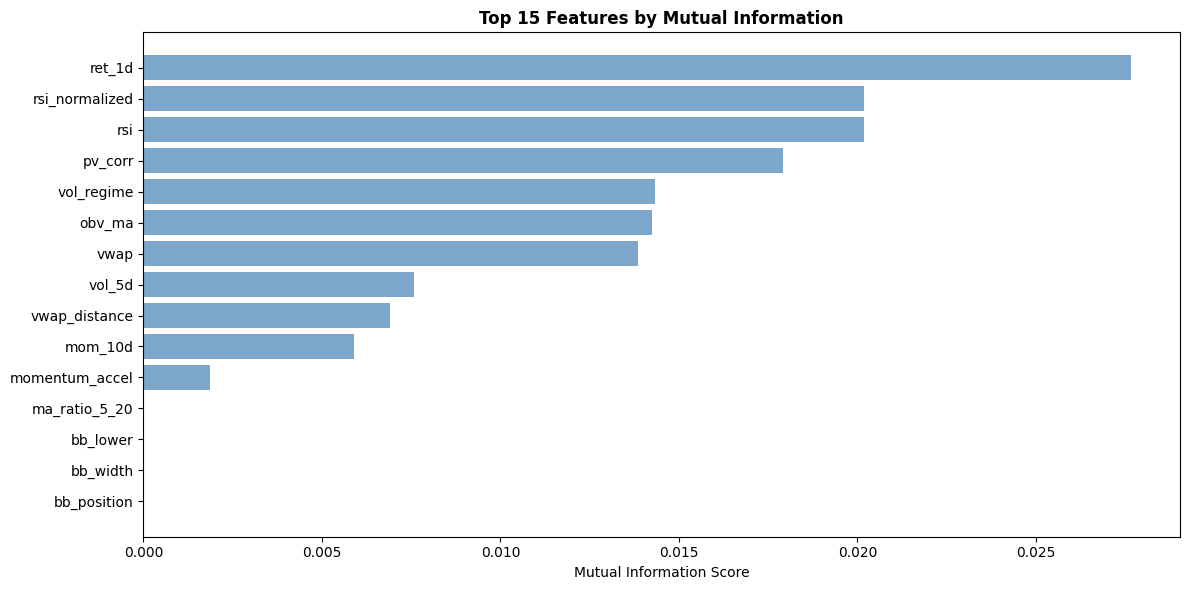

In [8]:
# ============================================================
# FILTER METHODS: MUTUAL INFORMATION
# ============================================================

print("FILTER METHODS: MUTUAL INFORMATION")
print("="*60)

# Mutual Information
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
mi_df = pd.DataFrame({
    'feature': feature_cols,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print("\nTop 10 by Mutual Information:")
print(mi_df.head(10).to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
top_15 = mi_df.head(15)
bars = ax.barh(range(len(top_15)), top_15['mi_score'].values, color='steelblue', alpha=0.7)
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels(top_15['feature'].values)
ax.set_xlabel('Mutual Information Score')
ax.set_title('Top 15 Features by Mutual Information', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 2.2 Wrapper Methods (RFE)

In [9]:
# ============================================================
# WRAPPER METHODS: RECURSIVE FEATURE ELIMINATION
# ============================================================

print("WRAPPER METHODS: RFE")
print("="*60)

# Use Random Forest for RFE
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rfe = RFE(rf, n_features_to_select=10, step=1)
rfe.fit(X_train, y_train)

rfe_features = [f for f, s in zip(feature_cols, rfe.support_) if s]
rfe_ranking = pd.DataFrame({
    'feature': feature_cols,
    'rank': rfe.ranking_
}).sort_values('rank')

print("\nTop 10 by RFE:")
print(rfe_ranking.head(10).to_string(index=False))

WRAPPER METHODS: RFE



Top 10 by RFE:
       feature  rank
        ret_1d     1
 parkinson_vol     1
       vol_60d     1
     macd_hist     1
       vol_10d     1
      bb_width     1
    volume_ma5     1
momentum_accel     1
  volume_ratio     1
       ret_60d     1


## 2.3 Embedded Methods (Feature Importance)

In [10]:
# ============================================================
# EMBEDDED METHODS: TREE-BASED IMPORTANCE
# ============================================================

print("EMBEDDED METHODS: FEATURE IMPORTANCE")
print("="*60)

# Random Forest importance
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 by Random Forest Importance:")
print(importance_df.head(10).to_string(index=False))

# Permutation importance (more reliable)
perm_imp = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

perm_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': perm_imp.importances_mean
}).sort_values('importance', ascending=False)

print("\nTop 10 by Permutation Importance:")
print(perm_df.head(10).to_string(index=False))

EMBEDDED METHODS: FEATURE IMPORTANCE

Top 10 by Random Forest Importance:
       feature  importance
  volume_ratio    0.037066
       vol_60d    0.035492
       ret_60d    0.032557
        ret_1d    0.032069
     vol_ratio    0.031614
momentum_accel    0.031467
    vol_of_vol    0.031294
    volume_ma5    0.031262
 parkinson_vol    0.030524
      bb_width    0.030153

Top 10 by Permutation Importance:
       feature  importance
  volume_ratio    0.007390
 ma_ratio_5_20    0.005774
       vol_60d    0.002540
          macd    0.001848
 parkinson_vol    0.001386
      bb_width    0.001386
rsi_normalized    0.001155
      bb_upper    0.000924
       vol_20d    0.000924
        obv_ma    0.000231


---

# Part 3: Model Explainability

## Why Explainability Matters in Finance

1. **Regulatory compliance** - MiFID II, GDPR require explanation of decisions
2. **Trust building** - Portfolio managers need to understand why
3. **Debugging** - Find data leakage or spurious correlations
4. **Domain validation** - Check if model learned sensible patterns

LINEAR MODEL COEFFICIENTS

Top 10 by Logistic Regression Coefficients:
       feature  coefficient
 ma_ratio_5_20     0.507879
ma_ratio_20_60     0.425174
 vwap_distance     0.317976
        obv_ma    -0.301604
       ret_60d    -0.300698
price_position    -0.224716
   macd_signal    -0.181107
          macd    -0.178812
      bb_lower     0.169821
        vol_5d     0.154778


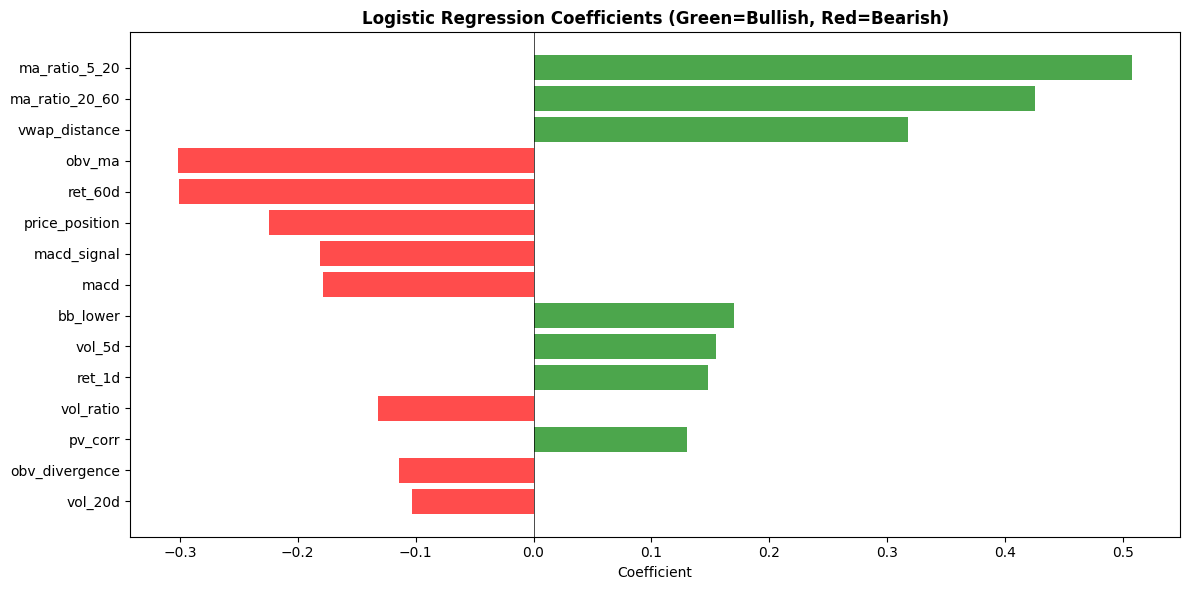

In [11]:
# ============================================================
# SIMPLE EXPLAINABILITY: COEFFICIENTS
# ============================================================

print("LINEAR MODEL COEFFICIENTS")
print("="*60)

# Logistic Regression coefficients
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train, y_train)

coef_df = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lr.coef_[0],
    'abs_coef': np.abs(lr.coef_[0])
}).sort_values('abs_coef', ascending=False)

print("\nTop 10 by Logistic Regression Coefficients:")
print(coef_df[['feature', 'coefficient']].head(10).to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
top_15 = coef_df.head(15)
colors = ['green' if c > 0 else 'red' for c in top_15['coefficient'].values]
bars = ax.barh(range(len(top_15)), top_15['coefficient'].values, color=colors, alpha=0.7)
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels(top_15['feature'].values)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlabel('Coefficient')
ax.set_title('Logistic Regression Coefficients (Green=Bullish, Red=Bearish)', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 3.1 SHAP Values (Simplified Implementation)

**SHAP** (SHapley Additive exPlanations) uses game theory to explain predictions.

$$\phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(|N|-|S|-1)!}{|N|!} [f(S \cup \{i\}) - f(S)]$$

In [ ]:
# ============================================================
# SIMPLIFIED SHAP-LIKE ANALYSIS
# ============================================================

print("SIMPLIFIED SHAP-LIKE ANALYSIS")
print("="*60)
print("⏱️ Note: This will take approximately 8-12 minutes to run.")
print("   Computing feature contributions for 200 samples...")

def calculate_shap_like(model, X, feature_names, n_samples=100):
    """
    Simplified SHAP-like feature contribution analysis.
    Uses permutation to measure feature impact.
    
    This implements the intuition behind SHAP:
    - For each sample, measure how each feature contributes to the prediction
    - Replace feature with its mean value and see how prediction changes
    
    Note: For production use, install the actual SHAP library: pip install shap
    """
    n_features = X.shape[1]
    baseline = model.predict_proba(X)[:, 1].mean()
    
    contributions = np.zeros((min(n_samples, len(X)), n_features))
    
    for i in range(min(n_samples, len(X))):
        if i % 50 == 0:
            print(f"   Processing sample {i}/{min(n_samples, len(X))}...")
        for j in range(n_features):
            X_permuted = X[i:i+1].copy()
            # Replace with mean (baseline)
            X_permuted[0, j] = X[:, j].mean()
            
            original_prob = model.predict_proba(X[i:i+1])[:, 1][0]
            permuted_prob = model.predict_proba(X_permuted)[:, 1][0]
            
            contributions[i, j] = original_prob - permuted_prob
    
    return contributions

# Calculate for test set
shap_values = calculate_shap_like(rf, X_test, feature_cols, n_samples=200)

# Mean absolute SHAP
mean_shap = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    'feature': feature_cols,
    'mean_shap': mean_shap
}).sort_values('mean_shap', ascending=False)

print("\n✅ SHAP computation complete!")
print("\nTop 10 by Mean |SHAP|:")
print(shap_df.head(10).to_string(index=False))

SIMPLIFIED SHAP-LIKE ANALYSIS
Computing SHAP-like values (this takes ~10-20 seconds)...

Top 10 by Mean |SHAP|:
      feature  mean_shap
      ret_60d     0.0463
     bb_upper     0.0414
         vwap     0.0275
       obv_ma     0.0228
     bb_lower     0.0226
    vol_ratio     0.0188
       ret_1d     0.0179
parkinson_vol     0.0178
 volume_ratio     0.0171
      pv_corr     0.0149


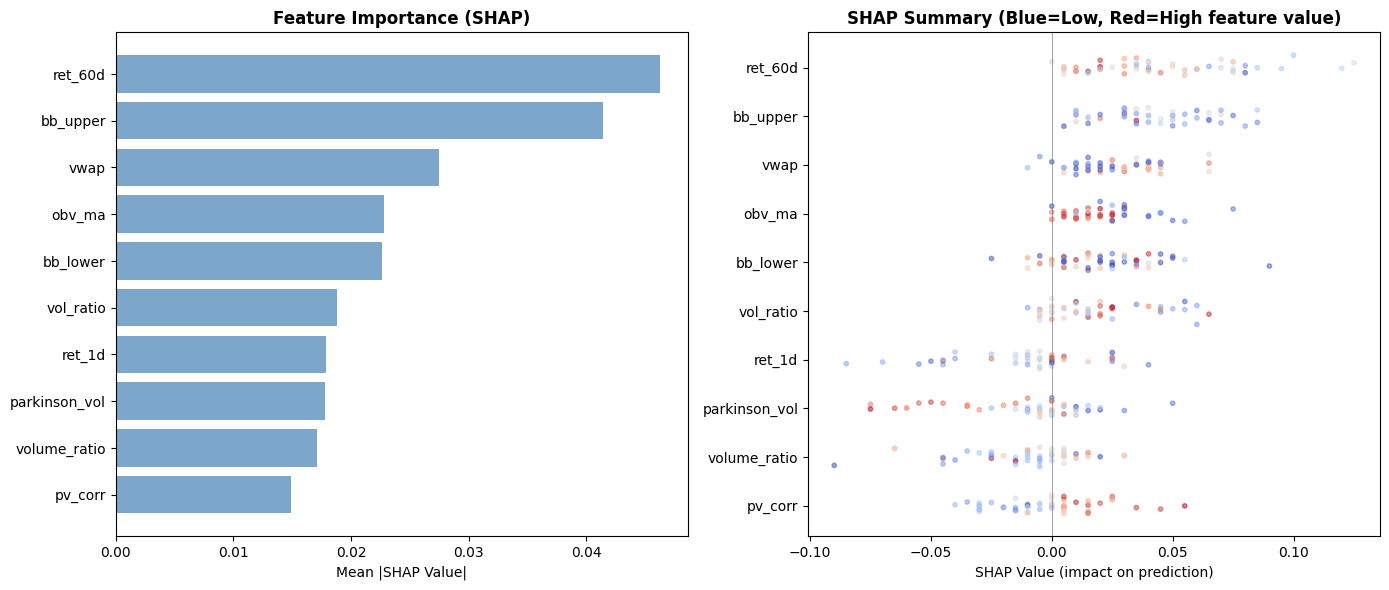

In [13]:
# ============================================================
# SHAP SUMMARY PLOT
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Feature importance bar
top_10 = shap_df.head(10)
axes[0].barh(range(len(top_10)), top_10['mean_shap'].values, color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(top_10)))
axes[0].set_yticklabels(top_10['feature'].values)
axes[0].set_xlabel('Mean |SHAP Value|')
axes[0].set_title('Feature Importance (SHAP)', fontweight='bold')
axes[0].invert_yaxis()

# SHAP beeswarm-like plot (simplified)
top_features_idx = [feature_cols.index(f) for f in top_10['feature'].values]
for i, (feat_idx, feat_name) in enumerate(zip(top_features_idx, top_10['feature'].values)):
    shap_vals = shap_values[:, feat_idx]
    feat_vals = X_test[:, feat_idx][:len(shap_vals)]
    
    # Normalize feature values for color
    norm_feat = (feat_vals - feat_vals.min()) / (feat_vals.max() - feat_vals.min() + 1e-10)
    
    y_jitter = i + np.random.randn(len(shap_vals)) * 0.1
    axes[1].scatter(shap_vals, y_jitter, c=norm_feat, cmap='coolwarm', alpha=0.5, s=10)

axes[1].set_yticks(range(len(top_10)))
axes[1].set_yticklabels(top_10['feature'].values)
axes[1].axvline(0, color='gray', linewidth=0.5)
axes[1].set_xlabel('SHAP Value (impact on prediction)')
axes[1].set_title('SHAP Summary (Blue=Low, Red=High feature value)', fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 3.2 Individual Prediction Explanation

In [ ]:
# ============================================================
# EXPLAIN SINGLE PREDICTION
# ============================================================

print("SINGLE PREDICTION EXPLANATION")
print("="*60)

# Pick a sample
sample_idx = 50
sample = X_test[sample_idx:sample_idx+1]
prediction = rf.predict_proba(sample)[0, 1]
actual = y_test[sample_idx]

# Get SHAP for this sample
sample_shap = shap_values[sample_idx]

# Sort by contribution
contrib_df = pd.DataFrame({
    'feature': feature_cols,
    'value': sample[0],
    'shap': sample_shap
}).sort_values('shap', key=abs, ascending=False)

print(f"\nPrediction: {prediction:.2%} probability of UP")
print(f"Actual: {'UP' if actual == 1 else 'DOWN'}")
print(f"\nTop contributors:")

for _, row in contrib_df.head(8).iterrows():
    direction = '+' if row['shap'] > 0 else '-'
    print(f"  {row['feature']:<25} value={row['value']:>8.3f}  {direction}{abs(row['shap']):.4f}")

SINGLE PREDICTION EXPLANATION

Prediction: 47.50% probability of UP
Actual: DOWN

Top contributors:
  ret_60d                   value=  -1.285  +0.0850
  parkinson_vol             value=   1.507  -0.0750
  volume_ma5                value=   1.375  -0.0450
  bb_width                  value=  -1.204  -0.0300
  mom_5d                    value=  -0.959  -0.0300
  vol_5d                    value=   1.770  -0.0250
  vwap                      value=   0.590  +0.0250
  vol_ratio                 value=   1.644  +0.0250


---

# Part 4: Putting It Together

In [16]:
# ============================================================
# FEATURE IMPORTANCE COMPARISON
# ============================================================

print("FEATURE IMPORTANCE: METHOD COMPARISON")
print("="*60)

# Combine all rankings
combined = pd.DataFrame({
    'feature': feature_cols,
    'mi_rank': mi_df.reset_index(drop=True).index + 1,
    'rf_rank': importance_df.reset_index(drop=True).index + 1,
    'perm_rank': perm_df.reset_index(drop=True).index + 1,
    'shap_rank': shap_df.reset_index(drop=True).index + 1
})

# Reorder to match original feature order
combined['mi_rank'] = combined['feature'].map(dict(zip(mi_df['feature'], range(1, len(mi_df)+1))))
combined['rf_rank'] = combined['feature'].map(dict(zip(importance_df['feature'], range(1, len(importance_df)+1))))
combined['perm_rank'] = combined['feature'].map(dict(zip(perm_df['feature'], range(1, len(perm_df)+1))))
combined['shap_rank'] = combined['feature'].map(dict(zip(shap_df['feature'], range(1, len(shap_df)+1))))

combined['avg_rank'] = combined[['mi_rank', 'rf_rank', 'perm_rank', 'shap_rank']].mean(axis=1)
combined = combined.sort_values('avg_rank')

print("\nTop 10 Features (Consensus):")
print(combined[['feature', 'avg_rank', 'mi_rank', 'rf_rank', 'shap_rank']].head(10).to_string(index=False))

FEATURE IMPORTANCE: METHOD COMPARISON

Top 10 Features (Consensus):
      feature  avg_rank  mi_rank  rf_rank  shap_rank
 volume_ratio      6.75       16        1          9
       ret_1d     12.00        1        4          7
ma_ratio_5_20     12.00       12       22         12
      vol_60d     12.25       31        2         13
       obv_ma     12.75        6       31          4
       vol_5d     12.75        8       14         15
    vol_ratio     13.00       28        5          6
parkinson_vol     13.00       30        9          8
     bb_width     13.25       14       10         23
     bb_upper     13.75       22       23          2


In [17]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║      WEEK 11 THEORY: FEATURE ENGINEERING & EXPLAINABILITY        ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  PART 1: FEATURE ENGINEERING                                     ║
║  • Return-based: momentum, acceleration, price position          ║
║  • Volatility: rolling std, Parkinson, vol-of-vol               ║
║  • Technical: RSI, MACD, Bollinger Bands                        ║
║  • Volume: OBV, VWAP, price-volume correlation                  ║
║                                                                  ║
║  PART 2: FEATURE SELECTION                                       ║
║  • Filter: Mutual Information, correlation                       ║
║  • Wrapper: Recursive Feature Elimination (RFE)                  ║
║  • Embedded: Tree importance, L1 regularization                  ║
║                                                                  ║
║  PART 3: EXPLAINABILITY                                          ║
║  • Linear: Coefficients (interpretable but limited)              ║
║  • SHAP: Game-theoretic feature contributions                    ║
║  • Permutation: Model-agnostic importance                        ║
║                                                                  ║
╚══════════════════════════════════════════════════════════════════╝

Daily Practice:
  Day 1-2: Build comprehensive feature library
  Day 3-4: Feature selection experiments
  Day 5-6: SHAP analysis & interpretation
  Day 7: Complete interpretable pipeline
""")


╔══════════════════════════════════════════════════════════════════╗
║      WEEK 11 THEORY: FEATURE ENGINEERING & EXPLAINABILITY        ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  PART 1: FEATURE ENGINEERING                                     ║
║  • Return-based: momentum, acceleration, price position          ║
║  • Volatility: rolling std, Parkinson, vol-of-vol               ║
║  • Technical: RSI, MACD, Bollinger Bands                        ║
║  • Volume: OBV, VWAP, price-volume correlation                  ║
║                                                                  ║
║  PART 2: FEATURE SELECTION                                       ║
║  • Filter: Mutual Information, correlation                       ║
║  • Wrapper: Recursive Feature Elimination (RFE)                  ║
║  • Embedded: Tree importance, L1 regularization                  ║
║                                   